In [1]:
import numpy as np
import astropy
from astropy.io import fits
from matplotlib import pyplot
import pandas as pd
import plotting as my_plot
import os

import auxil_ML as aux
import dio3 as dio

In [2]:
def h2cum(arr):
    res = 1. * arr[::-1]
    for i in range(1, len(arr)):
        res[i] += res[i - 1]
    return res[::-1]

In [147]:
#folder = '../ML_3FGL_paper_extra/data/python files/catas'
#folder = 'data'
folder = '../SOM'
cat = '3FGL'
pop = 'AGN' #'PSR', 'AGN'
quantity = 'Flux1000'
add_os = True
old = False

add_SP = 1
if cat != '3FGL':
    add_SP = False
#p3FGL_fn = '%s/%s_prob_catalog.csv' % (folder, cat)

In [148]:
try_os = False
if try_os:
    #weight_str = 'weighted'
    weight_str = 'oversample'
    fn = '../ML_3FGL_paper_extra/data/python files/catas/%s_unassoc_%s.csv' % (cat, weight_str)
    if 1:
        pcat_os = pd.read_csv(fn, index_col='Source_Name_%s' % cat)
    else:
        pcat_os = pd.read_csv(fn)
    print(pcat_os.columns)

In [149]:
my_plot.setup_figure_pars()
save_plots = 0
plot_assoc_prob = 1
correct_other = 1
test = 0
#add_os = True

alg0 = 'LR' # 'RF', 'BDT', 'LL', 'NN'
algs0 = ['RF', 'BDT', 'LR', 'NN']
if add_os:
    algs_os = [alg + '_O' for alg in algs0] # algorithms with oversampling
else:
    algs_os = []
algs = algs0 + algs_os
SP_algs = ['LR', 'RF']

prop_cycle = pyplot.rcParams['axes.prop_cycle']
cs = prop_cycle.by_key()['color']

#cat = '4FGL' # '3FGL', '4FGL'
if cat == '3FGL':
    fn_cat = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
else:
    #fn_cat = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
    fn_cat = '../PS_comparison/gll_psc_v27.fit' # 4FGL_DR2


if cat == '4FGL':
    #cat_name = '4FGL'
    cat_name = '4FGL-DR2'
else:
    cat_name = cat
    
#fn_pcat = '%s/%s_catalog_newfeats.csv' % (folder, cat)
fn_pcat = '%s/%s_prob_catalog_2classes.csv' % (folder, cat_name)
#fn_pcat = '%s/%s_prob_catalog_3class.csv' % (folder, cat)

if old:
    fn_pcat = fn_pcat.replace('.csv', '_old.csv')

if add_SP:
    SP_str = '_SazP'
else:
    SP_str = ''

if try_os:
    SP_str += '_%s' % weight_str
    if weight_str == 'weighted':
        alg0 = 'LR'
        algs = ['RF', 'BDT', 'LR']
if add_os:
    SP_str += '_add_os'
    
if old:
    SP_str += '_old'
    
figfn = 'plots/N_logS_%s_%s%s.pdf' % (cat_name, pop, SP_str)
figfn_diff = 'plots/N_logS_diff_%s_%s%s.pdf' % (cat, pop, SP_str)
    
hdu_cat = fits.open(fn_cat)
pcat_fgl = pd.read_csv(fn_pcat, index_col='Source_Name_%s' % cat)

index = np.array(hdu_cat[1].data.field('Source_Name'), dtype=str)
data = {quantity:np.array(hdu_cat[1].data.field(quantity), dtype=float)}
df_fgl = pd.DataFrame(data=data, index=index)
df_fgl.index = [st.strip() for st in df_fgl.index]

# load data from Saz Parkinson
pcat_SP = pd.read_csv('data/FGL3_results.csv', index_col='Source_Name')
pcat_SP.index = ['3FGL %s' %name.strip() for name in pcat_SP.index]

In [150]:
df_fgl_full = aux.hdu2df(hdu_cat[1], index_name='Source_Name')

In [151]:
df_fgl_full.columns

Index(['RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'Conf_68_SemiMajor',
       'Conf_68_SemiMinor', 'Conf_68_PosAng', 'Conf_95_SemiMajor',
       'Conf_95_SemiMinor', 'Conf_95_PosAng', 'ROI_num', 'Signif_Avg',
       'Pivot_Energy', 'Flux_Density', 'Unc_Flux_Density', 'Flux1000',
       'Unc_Flux1000', 'Energy_Flux100', 'Unc_Energy_Flux100', 'Signif_Curve',
       'SpectrumType', 'Spectral_Index', 'Unc_Spectral_Index', 'beta',
       'Unc_beta', 'Cutoff', 'Unc_Cutoff', 'Exp_Index', 'Unc_Exp_Index',
       'PowerLaw_Index', 'Flux30_100', 'Unc_Flux30_100', 'nuFnu30_100',
       'Sqrt_TS30_100', 'Flux100_300', 'nuFnu100_300', 'Sqrt_TS100_300',
       'Flux300_1000', 'nuFnu300_1000', 'Sqrt_TS300_1000', 'Flux1000_3000',
       'nuFnu1000_3000', 'Sqrt_TS1000_3000', 'Flux3000_10000',
       'nuFnu3000_10000', 'Sqrt_TS3000_10000', 'Flux10000_100000',
       'nuFnu10000_100000', 'Sqrt_TS10000_100000', 'Variability_Index',
       'Signif_Peak', 'Flux_Peak', 'Unc_Flux_Peak', 'Time_Peak',
       'Peak_I

In [152]:
pcat_fgl.columns

Index(['GLON', 'GLAT', 'ln(Energy_Flux100)', 'ln(Unc_Energy_Flux100)',
       'ln(Signif_Curve)', 'ln(Variability_Index)', '500MeV_Index', 'HR12',
       'HR23', 'HR34', 'HR45', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'Flags_3FGL', 'AGN_BDT', 'AGN_BDT_STD',
       'PSR_BDT', 'PSR_BDT_STD', 'AGN_NN', 'AGN_NN_STD', 'PSR_NN',
       'PSR_NN_STD', 'AGN_RF', 'AGN_RF_STD', 'PSR_RF', 'PSR_RF_STD', 'AGN_LR',
       'AGN_LR_STD', 'PSR_LR', 'PSR_LR_STD', 'AGN_BDT_O', 'AGN_BDT_STD_O',
       'PSR_BDT_O', 'PSR_BDT_STD_O', 'AGN_NN_O', 'AGN_NN_STD_O', 'PSR_NN_O',
       'PSR_NN_STD_O', 'AGN_RF_O', 'AGN_RF_STD_O', 'PSR_RF_O', 'PSR_RF_STD_O',
       'AGN_LR_O', 'AGN_LR_STD_O', 'PSR_LR_O', 'PSR_LR_STD_O',
       'Missing_Values_Flag', 'Category_Prob'],
      dtype='object')

In [153]:
classes = np.array([cl.strip() for cl in df_fgl_full['CLASS1']], dtype=str)
print(sum(classes == 'PSR') + sum(classes == 'psr'))
print(sum(pcat_fgl['Category_%s' %cat] == 'PSR'))

167
167


In [154]:
# flux or another value for associated and unassociated sources
if quantity == 'index':
    if cat == '3FGL':
        value_fgl = hdu_cat[1].data.field('Spectral_Index')
    else:
        value_fgl = hdu_cat[1].data.field('PL_Index')
elif quantity == 'Flux1000':
    df_fgl['value'] = np.log10(np.array(df_fgl[quantity]))


In [155]:
class_mask_fgl = (pcat_fgl['Category_%s' %cat] == pop)
unassoc_mask_fgl = (pcat_fgl['Category_%s' %cat] == 'UNAS')
all_assoc_mask_fgl = (pcat_fgl['Category_%s' %cat] != 'UNAS')
other_mask_fgl = (pcat_fgl['Category_%s' %cat] == 'OTHER')

#source_names_fgl = [name for name in pcat_fgl.index if class_mask_fgl_assoc[name]]
class_fgl_sources = [name for name in pcat_fgl.index if class_mask_fgl[name]]
all_assoc_fgl_sources = [name for name in pcat_fgl.index if all_assoc_mask_fgl[name]]
unassoc_fgl_sources = [name for name in pcat_fgl.index if unassoc_mask_fgl[name]]
other_fgl_sources = [name for name in pcat_fgl.index if other_mask_fgl[name]]

#minv = np.min(df_fgl.loc[class_fgl_sources, 'value'])
#maxv = np.max(df_fgl.loc[class_fgl_sources, 'value'])
bins = np.linspace(-10.5, -6.5, 17)
binsc = (bins[1:] + bins[:-1])/2
print(bins.shape)
print(np.sum(unassoc_mask_fgl))

(17,)
1010


In [156]:

# correction for other sources
other_values_fgl = df_fgl.loc[other_fgl_sources, 'value']

hist_all_assoc_fgl = np.histogram(df_fgl.loc[all_assoc_fgl_sources, 'value'], bins=bins)
hist_all_unassoc_fgl = np.histogram(df_fgl.loc[unassoc_fgl_sources, 'value'], bins=bins)
hist_class_fgl = np.histogram(df_fgl.loc[class_fgl_sources, 'value'], bins=bins)

unas_other_model_2classes = 1. * np.histogram(other_values_fgl, bins=bins)[0]
unas_other_model_2classes *= hist_all_unassoc_fgl[0] / (hist_all_assoc_fgl[0] + 0.00001)


other_fgl_corr = {}
other_fgl_class_corr = {}
for alg in algs:
    label = '%s_%s' % (pop, alg)
    probs = pcat_fgl.loc[other_fgl_sources, label]
    hist_other_fgl = np.histogram(other_values_fgl, bins=bins, weights=probs)
    if correct_other:
        other_fgl_corr[alg] = hist_other_fgl[0]/(hist_all_assoc_fgl[0] + 0.00001) * \
                    hist_all_unassoc_fgl[0]
        other_fgl_class_corr[alg] = hist_other_fgl[0]
    else:
        other_fgl_corr[alg] = np.zeros_like(hist_other_fgl[0])
        other_fgl_class_corr[alg] = np.zeros_like(hist_other_fgl[0])
        
if add_SP:
    other_SP_corr = {}
    other_SP_class_corr = {}
    for alg in SP_algs:
        label = '%s_P' % (alg)
        other_fgl_sources_SP = [name for name in other_fgl_sources if name in pcat_SP.index]
        probs = pcat_SP.loc[other_fgl_sources_SP, label]
        hist_other_SP = np.histogram(other_values_fgl[other_fgl_sources_SP], bins=bins, weights=probs)
        if correct_other:
            other_SP_corr[alg] = hist_other_SP[0]/(hist_all_assoc_fgl[0] + 0.00001) * \
                        hist_all_unassoc_fgl[0]
            other_SP_class_corr[alg] = hist_other_SP[0]
        else:
            other_SP_corr[alg] = np.zeros_like(hist_other_fgl[0])
            other_SP_class_corr[alg] = np.zeros_like(hist_other_fgl[0])



In [157]:
# estimated number of unas other sources
print(np.sum(unas_other_model_2classes))
print(unas_other_model_2classes)
print(hist_all_unassoc_fgl[0] / (hist_all_assoc_fgl[0] + 0.00001))

41.1452913241455
[0.         0.         0.         1.22905024 5.12748994 6.26666652
 7.76518187 6.74683502 8.90076268 2.30136955 2.2222216  0.2857142
 0.2999997  0.         0.         0.        ]
[0.         0.99999    0.48717936 0.61452512 0.5697211  0.44761904
 0.55465585 0.51898731 0.40458012 0.1917808  0.22222216 0.02857142
 0.0999999  0.         0.         0.        ]


In [158]:
def sub_dict(dct, keys):
    return {key:dct[key] for key in keys}

In [159]:
# probabilities and masks (for associated sources)
unassoc_values_fgl = df_fgl.loc[unassoc_fgl_sources, 'value']
class_values_fgl = df_fgl.loc[class_fgl_sources, 'value']
all_assoc_values_fgl = df_fgl.loc[all_assoc_fgl_sources, 'value']

hpcat_fgl = {}
hpcat_fgl_class = {}
prob_fgl_unassoc = {}
prob_fgl_class = {}

if try_os:
    prob_fgl_unassoc_os = {}
    hpcat_fgl_os = {}
    
for alg in algs:
    label = '%s_%s' % (pop, alg)
    prob_fgl_unassoc[alg] = np.array(pcat_fgl.loc[unassoc_fgl_sources, label]) # prob
    prob_fgl_class[alg] = np.array(pcat_fgl.loc[all_assoc_fgl_sources, label]) # prob
    hpcat_fgl[alg] = np.histogram(unassoc_values_fgl, bins=bins, 
                                   weights=prob_fgl_unassoc[alg])[0]
    hpcat_fgl_class[alg] = np.histogram(all_assoc_values_fgl, bins=bins, 
                                   weights=prob_fgl_class[alg])[0]
    
    if try_os:
        prob_fgl_unassoc_os[alg] = np.array(pcat_os.loc[unassoc_fgl_sources, label]) # prob
        hpcat_fgl_os[alg] = np.histogram(unassoc_values_fgl, bins=bins, 
                                       weights=prob_fgl_unassoc_os[alg])[0]

    


In [160]:
if add_SP:
    prob_SP_unassoc = {}
    prob_SP_class = {}
    hpcat_SP = {}
    hpcat_SP_class = {}
    for alg in SP_algs:
        label = '%s_P' % alg
        unassoc_fgl_sources_SP = [name for name in unassoc_fgl_sources if name in pcat_SP.index]
        all_assoc_fgl_sources_SP = [name for name in all_assoc_fgl_sources if name in pcat_SP.index]
        prob_SP_unassoc[alg] = np.array(pcat_SP.loc[unassoc_fgl_sources_SP, label]) # prob
        prob_SP_class[alg] = np.array(pcat_SP.loc[all_assoc_fgl_sources_SP, label]) # prob
        if pop != 'PSR':
            prob_SP_unassoc[alg] = 1 - prob_SP_unassoc[alg]
            prob_SP_class[alg] = 1 - prob_SP_class[alg]

        hpcat_SP[alg] = np.histogram(unassoc_values_fgl[unassoc_fgl_sources_SP], bins=bins, 
                                    weights=prob_SP_unassoc[alg])[0]
        hpcat_SP_class[alg] = np.histogram(all_assoc_values_fgl[all_assoc_fgl_sources_SP], bins=bins, 
                                   weights=prob_SP_class[alg])[0]



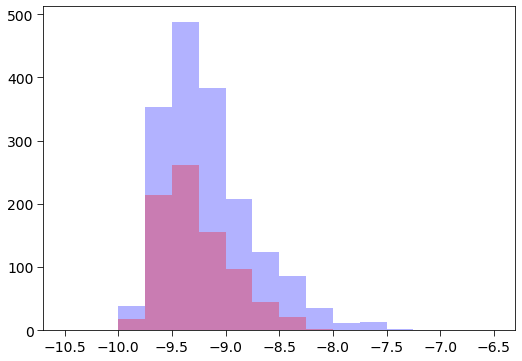

In [161]:
if 1:
    pyplot.figure()
    h3 = pyplot.hist(df_fgl.loc[class_fgl_sources, 'value'], 
                         bins=bins, color='b', alpha=0.3)
    hpcat_fgl0 = pyplot.hist(unassoc_values_fgl, bins=bins, color='r', 
                                alpha=0.3, weights=prob_fgl_unassoc[alg0])

In [162]:
def min_max_vs(dct, corr={}):
    vals = np.array([dct[key] - corr.get(key, 0.) for key in dct.keys()])
    return np.min(vals, axis=0), np.max(vals, axis=0)

In [163]:
hpcat_fgl0[0]/(h3[0] + 0.0000001)

array([0.        , 0.99999501, 0.460648  , 0.6080588 , 0.53470266,
       0.40441863, 0.46889922, 0.36669228, 0.24142066, 0.06998388,
       0.07314673, 0.00391096, 0.00254491, 0.        , 0.        ,
       0.        ])

In [164]:
hpcat_fgl_cum = {}
for key in hpcat_fgl:
    hpcat_fgl_cum[key] = aux.h2cum(hpcat_fgl[key])
hpcat_fgl_class_cum = {}
for key in hpcat_fgl_class:
    hpcat_fgl_class_cum[key] = aux.h2cum(hpcat_fgl_class[key])

other_fgl_corr_cum = {}
for key in other_fgl_corr:
    other_fgl_corr_cum[key] = aux.h2cum(other_fgl_corr[key])

other_fgl_class_corr_cum = {}
for key in other_fgl_class_corr:
    other_fgl_class_corr_cum[key] = aux.h2cum(other_fgl_class_corr[key])


Number of AGN among unassociated source in 3FGL: 3693.065 +- 519.895
Number of associated AGN: 1744.000
Cumulative source counts
[1.744e+03 1.744e+03 1.743e+03 1.704e+03 1.351e+03 8.630e+02 4.800e+02
 2.730e+02 1.490e+02 6.300e+01 2.800e+01 1.600e+01 3.000e+00 1.000e+00
 1.000e+00 0.000e+00]

Cumulative estimated numbers of AGN for LR corrected for other
[ 7.88164545e+02  7.88164545e+02  7.87164550e+02  7.69199278e+02
  5.55734404e+02  2.98875704e+02  1.49526465e+02  5.76754392e+01
  1.63323131e+01  9.50027096e-01  2.42520445e-02 -6.71143117e-02
 -2.72937467e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]

Associated
[0.00000000e+00 9.66569250e-01 3.64805385e+01 3.24357991e+02
 4.41827210e+02 3.49172705e+02 1.89712753e+02 1.10699654e+02
 8.21497312e+01 3.47627637e+01 1.08231961e+01 1.26587304e+01
 1.95116198e+00 5.73579570e-05 1.57346685e+00 1.44048850e-05] [0.00000000e+00 9.99546609e-01 3.87103287e+01 3.53500173e+02
 4.82689495e+02 3.78878693e+02 2.06408597e+02 1.22072139e+02
 8.

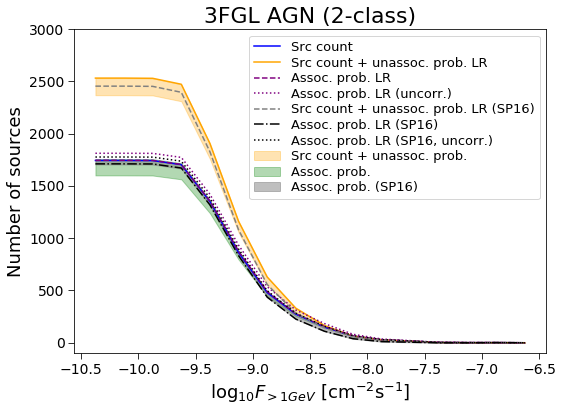

In [165]:
#plot = pyplot.semilogy 
plot = pyplot.plot
    
xs = binsc
pyplot.figure()
plot(xs, h2cum(h3[0]), c='blue', ls='-', label='Src count')
pcat_hist_fgl = hpcat_fgl[alg0] - other_fgl_corr[alg0]
pcat_hist_fgl_class = hpcat_fgl_class[alg0] - other_fgl_class_corr[alg0]


plot(xs, aux.h2cum(h3[0]) + aux.h2cum(pcat_hist_fgl), c='orange', ls='-', label='Src count + unassoc. prob. %s' % alg0)

minvs, maxvs = aux.min_max_vs(sub_dict(hpcat_fgl_cum, algs), corr=sub_dict(other_fgl_corr_cum, algs))
pyplot.fill_between(xs, h2cum(h3[0]) + minvs, h2cum(h3[0]) + maxvs, color='orange', alpha=0.3,
                    label='Src count + unassoc. prob.')

mean = h2cum(maxvs + minvs) / 2.
delta = h2cum(maxvs - minvs) / 2.
print('Number of %s among unassociated source in %s: %.3f +- %.3f' % (pop, cat, mean[0], delta[0]))
print('Number of associated %s: %.3f' % (pop, aux.h2cum(h3[0])[0]))
print('Cumulative source counts')
print(aux.h2cum(h3[0]))
print()
print('Cumulative estimated numbers of %s for %s corrected for other' % (pop, alg0))
print(aux.h2cum(pcat_hist_fgl))
print()

if try_os:
    pcat_hist_fgl_os = hpcat_fgl_os[alg0] - other_fgl_corr[alg0]
    plot(xs, h2cum(h3[0] + pcat_hist_fgl_os), c=cs[5], ls=':', label='Src count + unassoc. prob. oversample')

    
if plot_assoc_prob:
    plot(xs, h2cum(pcat_hist_fgl_class), c='purple', ls='--', label='Assoc. prob. %s' % alg0)
    plot(xs, h2cum(hpcat_fgl_class[alg0]), c='purple', ls=':', label='Assoc. prob. %s (uncorr.)' % alg0)
    minvs, maxvs = aux.min_max_vs(sub_dict(hpcat_fgl_class_cum, algs), corr=sub_dict(other_fgl_class_corr_cum, algs))
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.3, label='Assoc. prob.')
    if add_os:
        minvs, maxvs = aux.min_max_vs(sub_dict(hpcat_fgl_class, algs_os), corr=sub_dict(other_fgl_class_corr, algs_os))
        #pyplot.fill_between(xs, h2cum(minvs), h2cum(maxvs), color=cs[5], alpha=0.5)
        print('Associated')
        print(minvs, maxvs)
        
if add_os:
    minvs, maxvs = aux.min_max_vs(sub_dict(hpcat_fgl, algs_os), corr=sub_dict(other_fgl_corr, algs_os))
    print('Unassociated')
    print(minvs, maxvs)
    #pyplot.fill_between(xs, h2cum(h3[0] + minvs), h2cum(h3[0] + maxvs), color=cs[6], alpha=0.5)

        
    

if try_os:
    minvs, maxvs = aux.min_max_vs(hpcat_fgl_os, corr=other_fgl_corr)
    pyplot.fill_between(xs, h2cum(h3[0] + minvs), h2cum(h3[0] + maxvs), color=cs[5], alpha=0.5)
    
    mean = h2cum(maxvs + minvs) / 2.
    delta = h2cum(maxvs - minvs) / 2.
    print('Number of %s (os): %.1f +- %.1f' % (pop, mean[0], delta[0]))


if add_SP:
    pcat_hist_SP = hpcat_SP[alg0] - other_SP_corr[alg0]
    pcat_hist_SP_class = hpcat_SP_class[alg0] - other_SP_class_corr[alg0]

    plot(xs, h2cum(h3[0] + pcat_hist_SP), c='gray', ls='--', label='Src count + unassoc. prob. LR (SP16)')
    plot(xs, h2cum(pcat_hist_SP_class), c='black', ls='-.', label='Assoc. prob. LR (SP16)')
    plot(xs, h2cum(hpcat_SP_class[alg0]), c='black', ls=':', label='Assoc. prob. LR (SP16, uncorr.)')
    
    minvs, maxvs = aux.min_max_vs(hpcat_SP_class, corr=other_SP_class_corr)
    pyplot.fill_between(xs, h2cum(minvs), h2cum(maxvs), color='gray', alpha=0.5, label='Assoc. prob. (SP16)')
    #print('SP check')
    #print(h2cum(pcat_hist_SP_class), h2cum(minvs), h2cum(maxvs))
    #print(hpcat_SP_class)
    #print(other_SP_class_corr)


pyplot.xlabel(r'$\log_{10} F_{>1 GeV}\ [\rm cm^{-2}s^{-1}]$')
pyplot.ylabel('Number of sources')
pyplot.legend(fontsize=13, labelspacing=0.2)
if pop == 'AGN':
    if cat == '3FGL':
        pyplot.ylim(-100, 3000)
    else:
        pyplot.ylim(-170, 5000)
else:
    if cat == '3FGL':
        pyplot.ylim(-20, 600)
    else:
        pyplot.ylim(-1050/30, 1050)

title = '%s %s (2-class)' % (cat_name, pop)
if old:
    title += ' (old)'
#if plot_assoc_prob:
#    title += ' (%s)' % weight_str
pyplot.title(title)
if save_plots:
    print('Save figure to file:', figfn)
    pyplot.savefig(figfn)
    if not test:
        command = 'cp %s ../ML_3FGL_paper/plots' % figfn
        print(command)
        os.system(command)

In [166]:
if 0:
    print(hpcat_fgl.keys())
    print(hpcat_fgl_class.keys())
    print(other_fgl_corr.keys())
    print(other_fgl_class_corr.keys())
# save class and unassoc hists and expected contributions of other sources
dicts = {'%s_assoc' % pop: hpcat_fgl_class,
         '%s_unassoc' % pop: hpcat_fgl,
         '%s_assoc_other' % pop: other_fgl_class_corr,
         '%s_unassoc_other' % pop: other_fgl_corr
        }
for name, dct in dicts.items():
    fn = 'data/section6_plots/%s_%s.yaml' % (cat_name, name)
    #print(fn)
    dct['xs'] = xs
    dio.savedict(dct, fn)

save dict to file:
data/section6_plots/3FGL_AGN_assoc.yaml
save dict to file:
data/section6_plots/3FGL_AGN_unassoc.yaml
save dict to file:
data/section6_plots/3FGL_AGN_assoc_other.yaml
save dict to file:
data/section6_plots/3FGL_AGN_unassoc_other.yaml


In [167]:
cat

'3FGL'

In [168]:
pcat_hist_fgl

array([ 0.00000000e+00,  9.99995109e-01,  1.79652722e+01,  2.13464874e+02,
        2.56858700e+02,  1.49349239e+02,  9.18510259e+01,  4.13431261e+01,
        1.53822860e+01,  9.25775052e-01,  9.13663561e-02, -3.98205650e-02,
       -2.72937467e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [169]:
print(hpcat_fgl_class['RF'])
#print(hpcat_fgl_class['RF_O'])

[0.00000000e+00 9.27813645e-01 3.80523239e+01 3.51070233e+02
 4.90053170e+02 4.00892042e+02 2.22191150e+02 1.31606458e+02
 9.61904113e+01 4.24188989e+01 1.51378575e+01 1.69843928e+01
 3.11291209e+00 1.38203955e+00 1.38976038e+00 3.20456230e-02]


In [170]:
# checks
print('All unassociated surces')
print(hist_all_unassoc_fgl[0])
print('All associated surces')
print(hist_all_assoc_fgl[0])
print('Associated surces of %s class' % pop)
print(hist_class_fgl[0])
print(h3[0])
print('Other associated surces')
print(hist_other_fgl[0])
print('Estimated number of %s sources from probabilities' % pop)
print(pcat_hist_fgl_class)
print('Estimated number of %s sources among unassociated ones' % pop)
print(hpcat_fgl[alg0])
if try_os:
    print('Estimated number of %s sources among unassociated ones (%s)' % (pop, weight_str))
    print(hpcat_fgl_os[alg0])
    

All unassociated surces
[  0   1  19 220 286 188 137  82  53  14   8   1   1   0   0   0]
All associated surces
[  0   1  39 358 502 420 247 158 131  73  36  35  10   7   3   1]
Associated surces of AGN class
[  0   1  39 353 488 383 207 124  86  35  12  13   2   0   1   0]
[  0.   1.  39. 353. 488. 383. 207. 124.  86.  35.  12.  13.   2.   0.
   1.   0.]
Other associated surces
[ 0.          0.          0.          1.58995121  4.58317073 10.31983628
  5.49617582  4.23608404  7.72308564  4.37688519  2.73871641  1.97971677
  0.12133392  0.0451255   0.          0.        ]
Estimated number of AGN sources from probabilities
[0.00000000e+00 9.99565034e-01 3.85793911e+01 3.50349533e+02
 4.80229643e+02 3.85694905e+02 2.12681601e+02 1.22102714e+02
 8.91608713e+01 3.75188731e+01 1.18626778e+01 1.30287300e+01
 2.00971525e+00 3.09621964e-04 1.62104978e+00 9.15431817e-05]
Estimated number of AGN sources among unassociated ones
[0.00000000e+00 9.99995109e-01 1.79652722e+01 2.14644756e+02
 2.609348

In [171]:
print(other_fgl_corr[alg0] / (h3[0] + hpcat_fgl[alg0] + 0.0001))

[0.         0.         0.         0.00207856 0.00544266 0.01030521
 0.01713831 0.02435073 0.05039131 0.04068571 0.06106561 0.00694686
 0.01614987 0.         0.         0.        ]


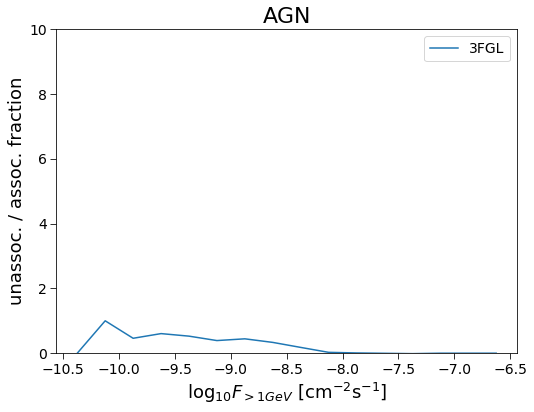

In [172]:
eps = 1.e-10
pyplot.rcParams['figure.subplot.left'] = 0.18
pyplot.rcParams['figure.subplot.right'] = 0.98

pyplot.figure()
pyplot.plot(binsc, pcat_hist_fgl / (h3[0] + eps), c=cs[0], ls='-', label=cat)
#pyplot.plot(binsc, hpcat_fgl0[0], c=cs[2], ls='--', label='fgl unassoc. prob.')
#pyplot.plot(binsc, np.sign(h4[0]) * pcat_hist_4fgl / (h4[0] + eps), c=cs[1], ls='-.', label='4FGL')
#pyplot.plot(binsc, hpcat_4fgl0[0], c=cs[3], ls=':', label='4FGL unassoc. prob.')

pyplot.legend()

pyplot.xlabel(r'$\log_{10} F_{>1 GeV}\ [\rm cm^{-2}s^{-1}]$')
pyplot.ylabel('unassoc. / assoc. fraction')
pyplot.ylim(0, 10)
pyplot.legend()
title = pop
#if plot_assoc_prob:
#    title += ' (%s)' % weight_str
pyplot.title(title)

if save_plots and 0:
    print('Save figure to file:', figfn_diff)
    pyplot.savefig(figfn_diff)

In [173]:
if 0:
    col_names3 = [hdu3[1].header[key] for key in hdu3[1].header.keys() if key.startswith('TTYPE')]
    col_names4 = [hdu4[1].header[key] for key in hdu4[1].header.keys() if key.startswith('TTYPE')]
    #print(col_names3)
    #print(col_names4)
    
    labels = {}
    labels['AGN'] = ["agn", "bcu", "bll", "css", "fsrq", "nlsy1", "rdg", "sey", "ssrq"]
    labels['PSR'] = ["PSR", "psr",]
    labels['other'] = ["bin", "hmb", "nov", "PSR", "psr", "pwn",  "snr", "spp", "glc", "sfr"]
    psclass4 = list(hdu4[1].data.field('CLASS1'))


In [174]:
if 0:
    psclass3 = list(hdu3[1].data.field('CLASS1'))
    psclass4 = list(hdu4[1].data.field('CLASS1'))

    n3 = len(psclass3)
    n4 = len(psclass4)

    inds3 = [i for i in range(n3) if psclass3[i] in pop_key]
    inds4 = [i for i in range(n4) if psclass4[i] in pop_key]

    
    print(len(value_pcat_fgl))
    print(len(prob), sum(prob))

In [175]:
N = len(pcat_SP['CLASS1'])
unass_SP = np.array([type(pcat_SP['CLASS1'][i]) != str for i in range(N)])

In [176]:
def nPSR(thres, pcat=pcat_SP, unass=unass_SP, methods=['LR_P', 'RF_P']):
    res = unass.copy()
    for method in methods:
        res = res & (pcat[method] > thres)
    return np.sum(res)


In [177]:
thress = np.arange(0.05, 1., 0.05)
nPSRs_SP = {}
nPSRs_SP['Joint SP'] = np.array([nPSR(thres) for thres in thress])
methods_SP = ['LR_P', 'RF_P']
for method in methods_SP:
    nPSRs_SP[method] = np.array([nPSR(thres, methods=[method]) for thres in thress])

In [178]:
pop_loc = 'PSR'
#fgl_methods = ['PSR_NN', 'PSR_LR', 'PSR_RF', 'PSR_BDT']
fgl_methods = ['%s_%s' % (pop_loc, alg) for alg in algs]
def nPSR_fgl(thres, methods=fgl_methods):
    return nPSR(thres, pcat=pcat_fgl, unass=unass_fgl, methods=methods)

In [179]:

unass_fgl = pcat_fgl['Category_%s' % cat] == 'UNAS'
print(np.sum((pcat_fgl['Category_Prob'] == 'PSR') & unass_fgl))
print(nPSR_fgl(0.5))

111
111


In [180]:
nPSR(0.5)

182

In [181]:
nPSRs_fgl = {}
nPSRs_fgl['Joint FGL'] = np.array([nPSR_fgl(thres) for thres in thress])
for method in fgl_methods:
    nPSRs_fgl[method] = np.array([nPSR_fgl(thres, methods=[method]) for thres in thress])


(0, 1)

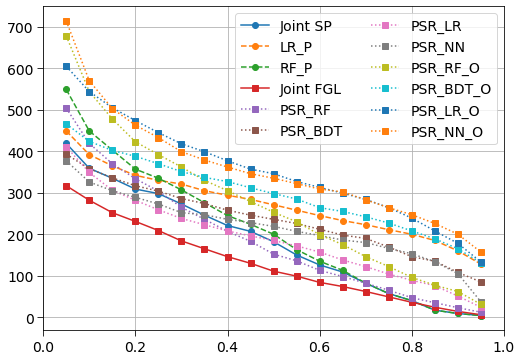

In [182]:
for key, nPSRs in nPSRs_SP.items():
    ls = '--'
    if key.startswith('Joint'):
        ls = '-'
    pyplot.plot(thress, nPSRs, ls=ls, marker='o', label=key)

for key, nPSRs in nPSRs_fgl.items():
    ls = ':'
    if key.startswith('Joint'):
        ls = '-'
    pyplot.plot(thress, nPSRs, ls=ls, marker='s', label=key)
    
pyplot.legend(ncol=2)
pyplot.grid()
pyplot.xlim(0, 1)